In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rnd
from scipy.stats import norm

### Jeu de données

In [2]:
'''

"alpha" <- 4.48        
"beta" <- 0.76         
"sigma2" <- 81.14      
"J" <- 3               
"y" <-
c(21, 20, 15)
"n" <-
c(48, 34, 21)
"Z" <-
c(10, 30, 50)


'''

y = np.array([21,20,15])
n = np.array([48,34,21])
Z = np.array([10,30,50])

data_air = np.zeros((3,3))
data_air[:,0] = y
data_air[:,1] = n
data_air[:,2] = Z

print(data_air)


[[21. 48. 10.]
 [20. 34. 30.]
 [15. 21. 50.]]


### Algo de Metropolis pour 5 paramètres

In [3]:
'''index_coord = rnd.choice(np.arange(5))
index_nocoord = np.where(np.arange(5) != index_coord)

index_coord, index_nocoord

a,b = np.array([1,2])

np.arange(start=0, stop=10, step = 2)
'''

'index_coord = rnd.choice(np.arange(5))\nindex_nocoord = np.where(np.arange(5) != index_coord)\n\nindex_coord, index_nocoord\n\na,b = np.array([1,2])\n\nnp.arange(start=0, stop=10, step = 2)\n'

In [48]:
def algo_metropolis_Air(nchain, obs, sigma_prop_theta1, sigma_prop_theta2, sigma_prop_X,  thinning_step = 1, nb_burn = 0, Init = np.zeros((1,5))):

    chain = np.zeros((nchain+1,5))  #Création de la chaîne de Markov
    
    index_thinning = np.arange(start=0, stop=nchain+1 - nb_burn, step=thinning_step)

    compt_acc = nchain # c'est le compteur d'acceptation, on l'initialise à la taille de la chaîne car on aura seulement la phase de rejet en fin d'algo donc on fera compt_acc - 1 à chaque rejet

    y = obs[:,0]
    n = obs[:,1]
    Z = obs[:,2]

    #Quelque hyperparamètre

    alpha = 4.48
    beta = 0.76
    sigma2 = 81.44

#Initialisation 
    
    chain[0,:] = Init


#Génération de la chaîne
    

    for i in range(nchain):

        index_coord = rnd.choice(np.arange(5))
        index_nocoord = np.where(np.arange(5) != index_coord)

        if(index_coord == 0):
            sigma_prop = sigma_prop_theta1
        else:
            if(index_coord == 1):
                sigma_prop = sigma_prop_theta2
            else:
                sigma_prop = sigma_prop_X
        
        

        prop = rnd.normal(chain[i,index_coord],sigma_prop)   #Noyau de proposition symétrique

        chain[i+1,index_coord] = prop   #On a besoin de "savoir" quelle coordonnées on a modifié donc on met la coord modifiée dans la chaîne comme si on acceptait la proposition
        chain[i+1,index_nocoord] = chain[i,index_nocoord]

        theta1, theta2, X1,X2,X3 = chain[i,:] 
        theta1_prop, theta2_prop, X1_prop,X2_prop,X3_prop = chain[i+1,:] 

        p1,p2,p3 = np.array([1/(1 + np.exp(-(theta1 + theta2*X1)))   ,   1/(1 + np.exp(-(theta1 + theta2*X2)))    ,  1/(1 + np.exp(-(theta1 + theta2*X3)))])
        p1_prop, p2_prop,p3_prop = np.array([1/(1 + np.exp(-(theta1_prop + theta2_prop*X1_prop)))   ,   1/(1 + np.exp(-(theta1_prop + theta2_prop*X2_prop)))    ,  1/(1 + np.exp(-(theta1_prop + theta2_prop*X3_prop)))])
        
        
        
        g_Y = np.array([p1**n[0]*(1-p1)**(n[0]-y[0]),  p2**n[1]*(1-p2)**(n[1]-y[1])   ,  p3**n[2]*(1-p3)**(n[2]-y[2])])
        g_theta1 = norm.pdf(theta1,0,np.sqrt(1000))
        g_theta2 = norm.pdf(theta2,0,np.sqrt(1000))
        g_X1 = norm.pdf(X1, alpha + beta*Z[0],np.sqrt(sigma2))
        g_X2 = norm.pdf(X2, alpha + beta*Z[1],np.sqrt(sigma2))
        g_X3 = norm.pdf(X3, alpha + beta*Z[2],np.sqrt(sigma2))

        prob_inf = np.sum(np.log(g_Y)) + np.log(g_theta1) + np.log(g_theta2) + np.log(g_X1) + np.log(g_X2) + np.log(g_X3)



        g_Y_new = np.array([p1_prop**n[0]*(1-p1_prop)**(n[0]-y[0]),  p2_prop**n[1]*(1-p2_prop)**(n[1]-y[1])   ,  p3_prop**n[2]*(1-p3_prop)**(n[2]-y[2])])
        g_theta1_new = norm.pdf(theta1_prop,0,np.sqrt(1000))
        g_theta2_new = norm.pdf(theta2_prop,0,np.sqrt(1000))
        g_X1_new = norm.pdf(X1_prop, alpha + beta*Z[0],np.sqrt(sigma2))
        g_X2_new = norm.pdf(X2_prop, alpha + beta*Z[1],np.sqrt(sigma2))
        g_X3_new = norm.pdf(X3_prop, alpha + beta*Z[2],np.sqrt(sigma2))

        prob_sup = np.sum(np.log( g_Y_new)) + np.log(g_theta1_new) + np.log(g_theta2_new) + np.log(g_X1_new) + np.log(g_X2_new) + np.log(g_X3_new)


        #print(prob_inf)
        #print(prob_sup)

        alpha_acc = np.min((0, prob_sup - prob_inf))

        #print(alpha_acc)

        log_U = np.log(rnd.uniform())

        if (log_U > alpha_acc):
            chain[i+1,index_coord] = chain[i,index_coord]   #On a seulement l'étape de rejet car on a déjà accepté la nouvelle proposition pour les besoins de l'algo
            compt_acc -= 1


    chain = chain[np.arange(nb_burn, nchain+1),:]  # Période de burn
    chain = chain[index_thinning,:]   #Elagage de la chaîne

    return(chain, compt_acc/nchain)




    


In [164]:
CHAIN, compt_acc = algo_metropolis_Air(50000, data_air, 0.5, 0.02, 15 , thinning_step=10, nb_burn=2000)

In [165]:
compt_acc

0.45012

In [166]:
CHAIN.shape

(4801, 5)

In [167]:
THETA1 = CHAIN[:,0]
THETA2 = CHAIN[:,1]
X1 = CHAIN[:,2]
X2 = CHAIN[:,3]
X3 = CHAIN[:,4]

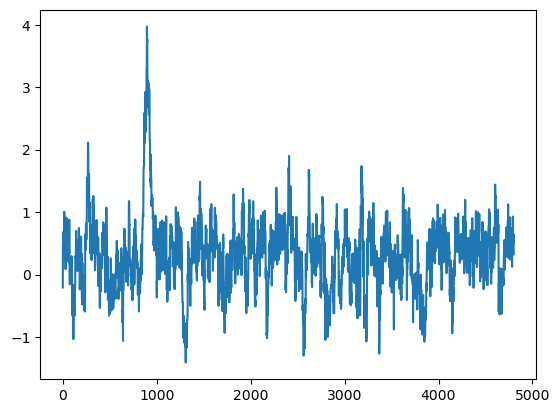

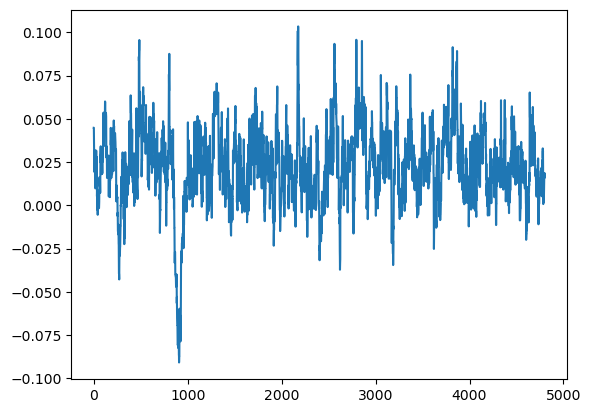

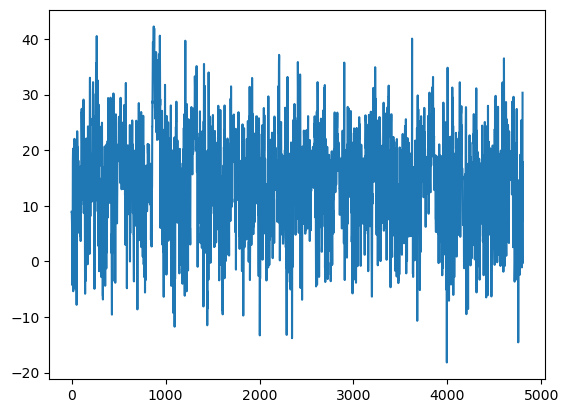

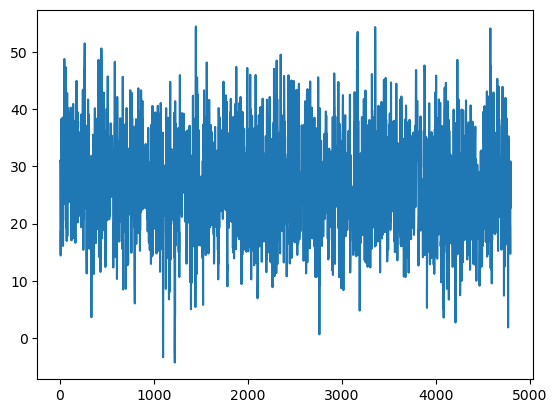

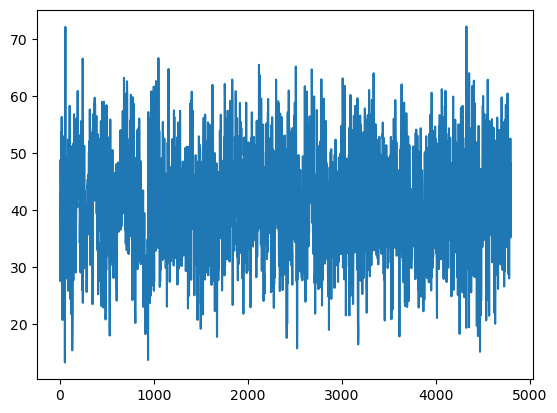

In [168]:
plt.plot(THETA1)
plt.show()
plt.plot(THETA2)
plt.show()
plt.plot(X1)
plt.show()
plt.plot(X2)
plt.show()
plt.plot(X3)
plt.show()

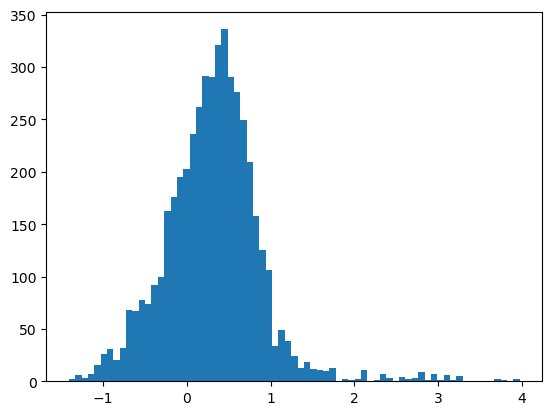

0.31128216822120613
0.5746220063114619


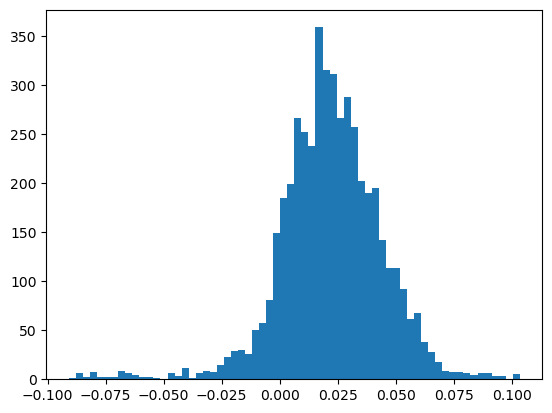

0.022067778378716953
0.02190276033663997


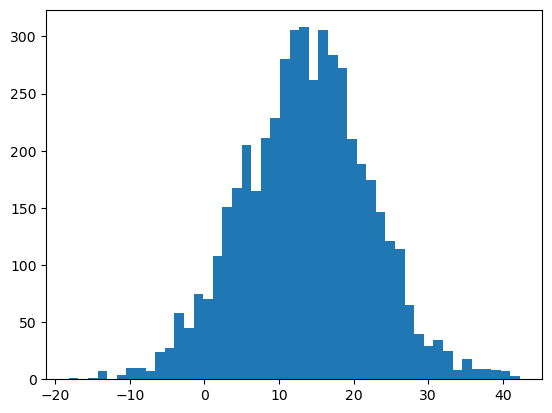

13.632408591777104
8.544367179628976


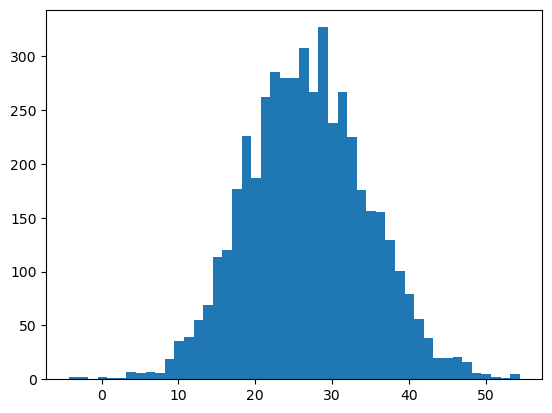

26.75118682456325
8.71705921656088


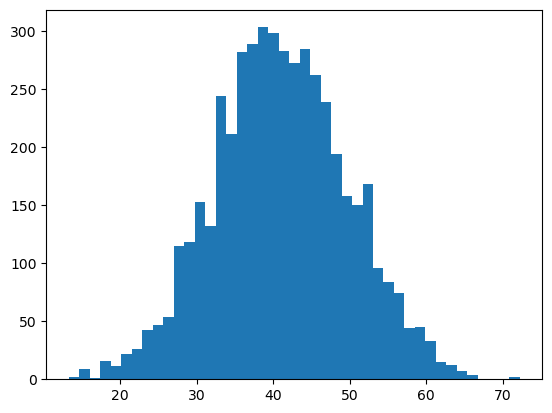

41.073915901719204
8.71705921656088


In [169]:
plt.hist(THETA1, bins = "auto")
plt.show()
print(np.mean(THETA1))
print(np.std(THETA1))
plt.hist(THETA2, bins = "auto")
plt.show()
print(np.mean(THETA2))
print(np.std(THETA2))
plt.hist(X1, bins = "auto")
plt.show()
print(np.mean(X1))
print(np.std(X1))
plt.hist(X2, bins = "auto")
plt.show()
print(np.mean(X2))
print(np.std(X3))
plt.hist(X3, bins = "auto")
plt.show()
print(np.mean(X3))
print(np.std(X3))

In [170]:
P1 = 1/(1+np.exp(-(THETA1 + THETA2*X1)))
P2 = 1/(1+np.exp(-(THETA1 + THETA2*X2)))
P3 = 1/(1+np.exp(-(THETA1 + THETA2*X3)))

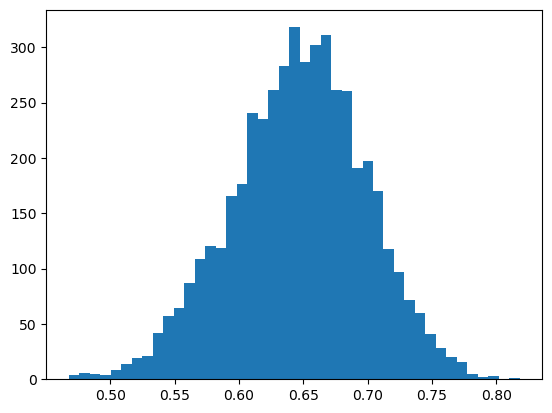

0.6465816274648378


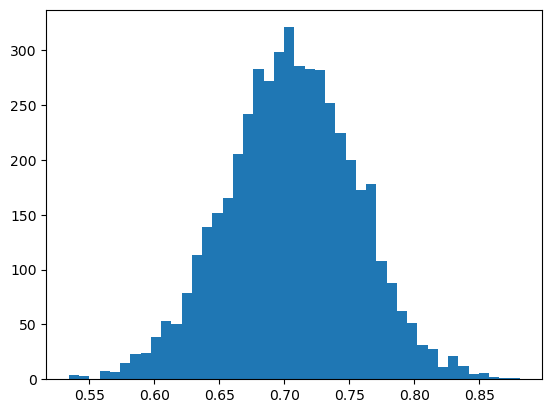

0.7051714642578637


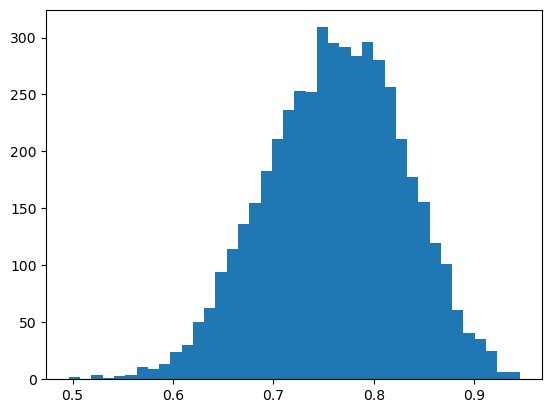

0.76135682858441


In [174]:
plt.hist(P1, bins = "auto")
plt.show()

print(np.mean(P1))

plt.hist(P2, bins = "auto")
plt.show()

print(np.mean(P2))

plt.hist(P3, bins = "auto")
plt.show()

print(np.mean(P3))

### Essai avec un algo de Metropolis sur chaque classe

In [172]:
'''

y = np.array([21,20,15])
n = np.array([48,34,21])
Z = np.array([10,30,50])

data_air = np.zeros((3,3))
data_air[:,0] = y
data_air[:,1] = n
data_air[:,2] = Z

print(data_air)

'''

'\n\ny = np.array([21,20,15])\nn = np.array([48,34,21])\nZ = np.array([10,30,50])\n\ndata_air = np.zeros((3,3))\ndata_air[:,0] = y\ndata_air[:,1] = n\ndata_air[:,2] = Z\n\nprint(data_air)\n\n'

In [173]:
'''def algo_metropolis_Air(nchain, obs, sigma_prop_theta1, sigma_prop_theta2, sigma_prop_X,  thinning_step = 1, nb_burn = 0, Init = np.zeros((1,3))):

    chain = np.zeros((nchain+1,3))  #Création de la chaîne de Markov
    
    index_thinning = np.arange(start=0, stop=nchain+1 - nb_burn, step=thinning_step)

    compt_acc = nchain # c'est le compteur d'acceptation, on l'initialise à la taille de la chaîne car on aura seulement la phase de rejet en fin d'algo donc on fera compt_acc - 1 à chaque rejet

    y = obs[:,0]
    n = obs[:,1]
    Z = obs[:,2]

    #Quelque hyperparamètre

    alpha = 4.48
    beta = 0.76
    sigma2 = 81.44

#Initialisation 
    
    chain[0,:] = Init


#Génération de la chaîne
    

    for i in range(nchain):

        index_coord = rnd.choice(np.arange(3))
        index_nocoord = np.where(np.arange(3) != index_coord)

        if(index_coord == 0):
            sigma_prop = sigma_prop_theta1
        else:
            if(index_coord == 1):
                sigma_prop = sigma_prop_theta2
            else:
                sigma_prop = sigma_prop_X
        
        

        prop = rnd.normal(chain[i,index_coord],sigma_prop)   #Noyau de proposition symétrique

        chain[i+1,index_coord] = prop   #On a besoin de "savoir" quelle coordonnées on a modifié donc on met la coord modifiée dans la chaîne comme si on acceptait la proposition
        chain[i+1,index_nocoord] = chain[i,index_nocoord]

        theta1, theta2, Xi = chain[i,:] 
        theta1_prop, theta2_prop, Xi_prop = chain[i+1,:] 

        pi = 1/(1 + np.exp(-(theta1 + theta2*Xi)))
        pi_prop = 1/(1 + np.exp(-(theta1_prop + theta2_prop*Xi_prop)))
        
        
        
        g_Y = pi**n[0]*(1-pi)**(n[0]-y[0])
        g_theta1 = norm.pdf(theta1,0,np.sqrt(1000))
        g_theta2 = norm.pdf(theta2,0,np.sqrt(1000))
        g_Xi = norm.pdf(Xi, alpha + beta*Z[0],np.sqrt(sigma2))

        prob_inf = np.log(g_Y) + np.log(g_theta1) + np.log(g_theta2) + np.log(g_Xi) #Les modif ont été arrêtées ici



        g_Y_new = np.array([p1_prop**n[0]*(1-p1_prop)**(n[0]-y[0]),  p2_prop**n[1]*(1-p2_prop)**(n[1]-y[1])   ,  p3_prop**n[2]*(1-p3_prop)**(n[2]-y[2])])
        g_theta1_new = norm.pdf(theta1_prop,0,np.sqrt(1000))
        g_theta2_new = norm.pdf(theta2_prop,0,np.sqrt(1000))
        g_X1_new = norm.pdf(X1_prop, alpha + beta*Z[0],np.sqrt(sigma2))
        g_X2_new = norm.pdf(X2_prop, alpha + beta*Z[1],np.sqrt(sigma2))
        g_X3_new = norm.pdf(X3_prop, alpha + beta*Z[2],np.sqrt(sigma2))

        prob_sup = np.sum(np.log( g_Y_new)) + np.log(g_theta1_new) + np.log(g_theta2_new) + np.log(g_X1_new) + np.log(g_X2_new) + np.log(g_X3_new)


        #print(prob_inf)
        #print(prob_sup)

        alpha_acc = np.min((0, prob_sup - prob_inf))

        #print(alpha_acc)

        log_U = np.log(rnd.uniform())

        if (log_U > alpha_acc):
            chain[i+1,index_coord] = chain[i,index_coord]   #On a seulement l'étape de rejet car on a déjà accepté la nouvelle proposition pour les besoins de l'algo
            compt_acc -= 1


    chain = chain[np.arange(nb_burn, nchain+1),:]  # Période de burn
    chain = chain[index_thinning,:]   #Elagage de la chaîne

    return(chain, compt_acc/nchain)


'''

    


'def algo_metropolis_Air(nchain, obs, sigma_prop_theta1, sigma_prop_theta2, sigma_prop_X,  thinning_step = 1, nb_burn = 0, Init = np.zeros((1,3))):\n\n    chain = np.zeros((nchain+1,3))  #Création de la chaîne de Markov\n    \n    index_thinning = np.arange(start=0, stop=nchain+1 - nb_burn, step=thinning_step)\n\n    compt_acc = nchain # c\'est le compteur d\'acceptation, on l\'initialise à la taille de la chaîne car on aura seulement la phase de rejet en fin d\'algo donc on fera compt_acc - 1 à chaque rejet\n\n    y = obs[:,0]\n    n = obs[:,1]\n    Z = obs[:,2]\n\n    #Quelque hyperparamètre\n\n    alpha = 4.48\n    beta = 0.76\n    sigma2 = 81.44\n\n#Initialisation \n    \n    chain[0,:] = Init\n\n\n#Génération de la chaîne\n    \n\n    for i in range(nchain):\n\n        index_coord = rnd.choice(np.arange(3))\n        index_nocoord = np.where(np.arange(3) != index_coord)\n\n        if(index_coord == 0):\n            sigma_prop = sigma_prop_theta1\n        else:\n            if(index